# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [118]:
import numpy as np
import random
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [119]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x=df['x'].to_numpy()
y=df['y'].to_numpy()
SNR=df['SNR'].to_numpy()


## Helper functions

These functions will help us evaluate the results

In [120]:
def compute_distance(x, y):
    distance=(x**2+y**2)**(1/2)
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)     

def predict(distance, poly_coeffs, degree):
    # Predict the SNR from a given model
    SNR=sum([poly_coeffs[degree-deg]*distance**deg for deg in range(degree+1)])
    return SNR      #is an array of predicted SNR

def evaluate(distance, SNR, poly_coeffs, degree):
    # Compute the error of the polynomial fit on the chosen data with mean square error
    MSE=sum((predict(distance,poly_coeffs,degree)-SNR)**2)
    return MSE

def separate_test(distance, SNR, test_points):
    # Return a training set and a test set (the test_points parameter controls the number of test points).
    # The points should be selected randomly, so i first create an array of random indices of size test_points
    idx=np.arange(len(distance))
    np.random.shuffle(idx)
    distance_test=distance[idx[:test_points]]
    distance_train=distance[idx[test_points:]]
    SNR_test=SNR[idx[:test_points]]
    SNR_train=SNR[idx[test_points:]]
    return distance_train, SNR_train, distance_test, SNR_test

Text(0, 0.5, 'SNR')

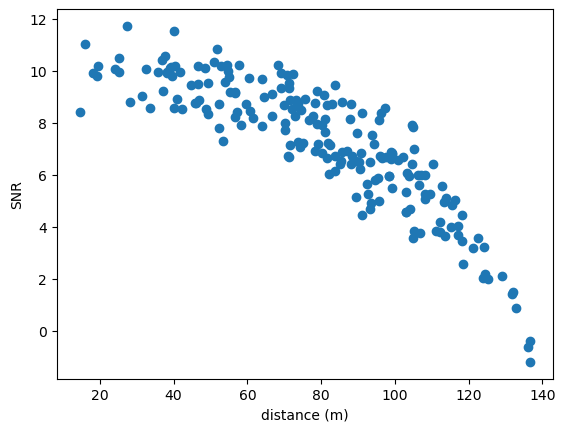

In [121]:
# separate the training and test sets and create a scatter plot of the SNR as a function of the distance
distance = compute_distance(x,y)
(dist_train, SNR_train, dist_test, SNR_test)=separate_test(distance, SNR, 40)

plt.plot(distance, SNR, 'o')
plt.xlabel('distance (m)')
plt.ylabel('SNR')



## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [122]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # Perform K-fold cross-validation on the training set.
    # The two returned values are the best model (coefficient) and the list of results (performance) for all degrees up to max_degree.
    # The points should be selected randomly.
    fold_pt=len(x_train)//k
    x_fold=[]
    y_fold=[]
    idx=np.arange(len(x_train))
    np.random.shuffle(idx)
    for i in range(k):                              #partition into folds
        x_fold.append(x_train[i*fold_pt : (i+1)*fold_pt])
        y_fold.append(y_train[i*fold_pt : (i+1)*fold_pt])

    best=-1
    best_perf=9e10
    results=[]

    for degree in range(max_degree+1):
        deg_perf=0
        for i in range(k):
            x_k_fold=np.concatenate([x_fold[l] for l in range(k) if l != i])
            y_k_fold=np.concatenate([y_fold[l] for l in range(k) if l != i])
            w=fit(x_k_fold, y_k_fold, degree)
            deg_perf+=evaluate(x_fold[i], y_fold[i], w, degree)
        deg_perf/=k
        results.append(deg_perf)
        if deg_perf < best_perf:
            best_perf = deg_perf
            best=fit(x_train, y_train, degree)
    # The inputs and labels are already in terms of distance and SNR
    return best, results

Text(0, 0.5, 'loss')

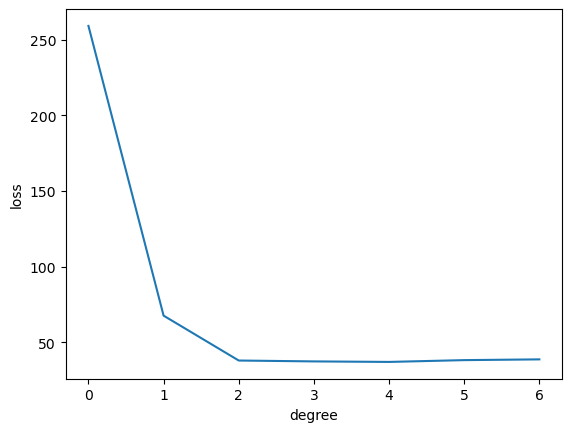

In [123]:
k_fold_results=k_fold_cross_validation(dist_train, SNR_train, 4, 6)

plt.plot(k_fold_results[1])
plt.xlabel("degree")
plt.ylabel("loss")

Text(0.5, 1.0, 'K-fold validation')

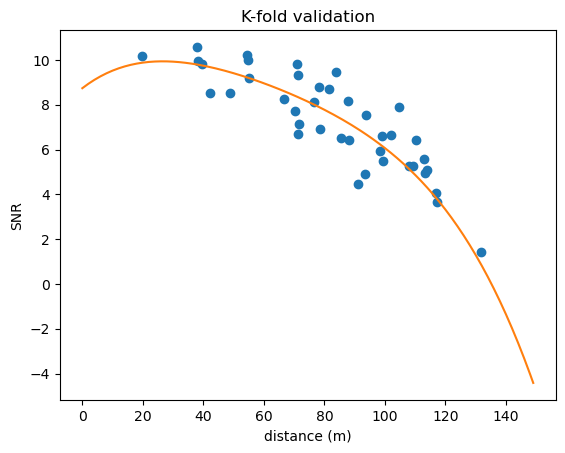

In [124]:
#  get the test performance of the best model and plot the model output and test points. 
k_degree=len(k_fold_results[0])-1
k_predict=predict(np.arange(150), k_fold_results[0], k_degree)

plt.plot(dist_test, SNR_test, 'o')
plt.plot(np.arange(150), k_predict)
plt.xlabel('distance (m)')
plt.ylabel('SNR')
plt.title('K-fold validation')
# Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=1$) THIS GETS VERY STRONG REGULARIZATION, TRY $\lambda=0.01$

In [125]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # apply Tikhonov regularization AFTER the fitting process
    best=-1
    best_perf=9e10
    results=[]

    for degree in range(max_degree+1):
        p=fit(x_train, y_train, degree)
        deg_perf=evaluate(x_train, y_train, p, degree)+lambda_par*np.linalg.norm(p)**2
        results.append(deg_perf)
        if deg_perf < best_perf:
            best_perf = deg_perf
            best=p
        #first fit for each degree, then regularize
    return best, results

Text(0, 0.5, 'loss')

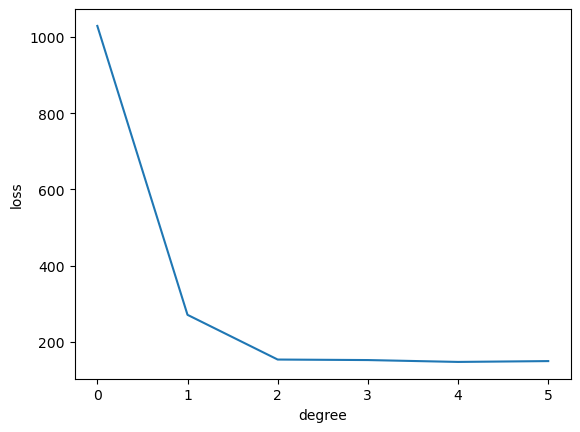

In [126]:
lamb=0.1
t_results=evaluate_tikhonov(dist_train, SNR_train, lamb, 5)    #with max degree 6 is unstable
t_degree=len(t_results[0])-1

plt.plot(t_results[1])
plt.xlabel("degree")
plt.ylabel("loss")

Text(0.5, 1.0, 'Tikhonov regularization')

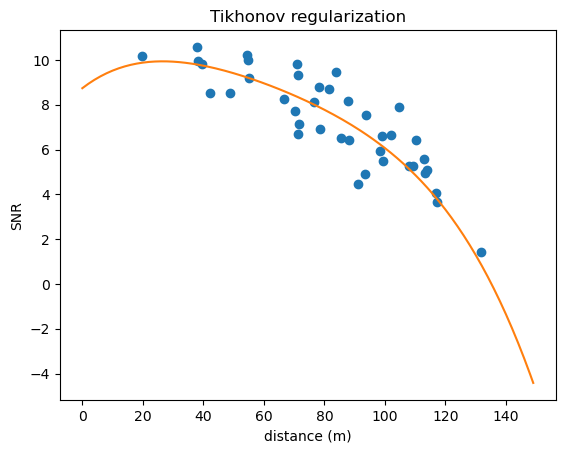

In [127]:
t_predict=predict(np.arange(150), t_results[0], t_degree)

plt.plot(dist_test, SNR_test, 'o')
plt.plot(np.arange(150), t_predict)
plt.xlabel('distance (m)')
plt.ylabel('SNR')
plt.title('Tikhonov regularization')

## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=1$

In [128]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    best=-1
    best_perf=9e10
    results=[]

    for degree in range(max_degree+1):
        p=fit(x_train, y_train, degree)
        deg_perf=evaluate(x_train, y_train, p, degree)+lambda_par*2**degree
        results.append(deg_perf)
        if deg_perf < best_perf:
            best_perf = deg_perf
            best=p
        #first fit for each degree, then regularize
    return best, results


Text(0, 0.5, 'loss')

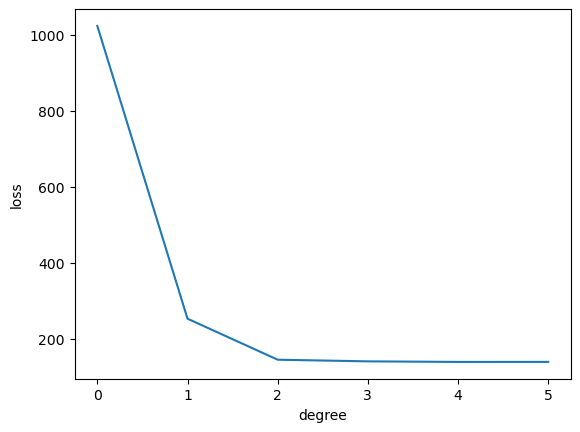

In [129]:
lamb=0.02
c_results=evaluate_representation(dist_train, SNR_train, lamb, 5)    #with max degree 6 is unstable
c_degree=len(c_results[0])-1
c_predict=predict(np.arange(150), c_results[0], c_degree)


plt.plot(c_results[1])
plt.xlabel("degree")
plt.ylabel("loss")



### TEST

Check the performance of the three solutions on the test set: which one does best?


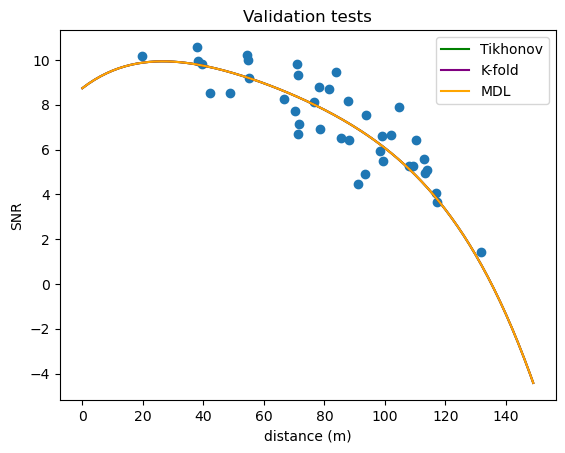

Scores:
K-fold:  43.337606450424275 Tikhonov:  43.337606450424275 MDL:  43.337606450424275


In [130]:
plt.plot(dist_test, SNR_test, 'o')
plt.plot(np.arange(150), t_predict, c='green', label='Tikhonov')
plt.plot(np.arange(150), k_predict, c='purple', label='K-fold')
plt.plot(np.arange(150), c_predict, c='orange', label='MDL')
plt.xlabel('distance (m)')
plt.ylabel('SNR')
plt.title('Validation tests')
plt.legend()

plt.show()

k_perf=evaluate(dist_test, SNR_test, k_fold_results[0], k_degree)
t_perf=evaluate(dist_test, SNR_test, t_results[0], t_degree)
c_perf=evaluate(dist_test, SNR_test, c_results[0], c_degree)

print('Scores:\nK-fold: ', k_perf, 'Tikhonov: ', t_perf, 'MDL: ', c_perf)